Given data has huge imbalance in data groups, so we decided instead of downsampling the data and loosing the information, we thought of creating two models 


First model will predict it belongs to GRP_0 or not. If it's not belonging to GRP_0 then it will pass the ticket description to the second model to predict its group


Second model will take the input and again it will tokenize and it will predict the actul group of it.




#First Model

## Namespace

In [1]:
import tensorflow
tensorflow.__version__

'2.8.0'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Embedding,Bidirectional, GRU
from tensorflow.keras import layers, models, Model, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Import Data

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
embeddings_index = {}
f = open('/content/drive/My Drive/Great Learning/Projects/NLP/glove.6B.100d.txt', encoding="utf8")
#f = open('/content/drive/My Drive/Great Learning/Projects/NLP/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [5]:
df = pd.read_pickle("/content/drive/My Drive/Great Learning/Capstone/cleaned_translated_df.pkl")
df

,Description,Assignment group,Language,Translated Description,Cleaned Description,Translated Description After Clean,Language After Cleaned and Translated
0,login issue -verified user details.(employee# ...,GRP_0,en,login issue -verified user details.(employee# ...,login issue verify user detail employee manage...,login issue verify user detail employee manage...,en
1,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,GRP_0,en,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,outlook team meeting skype meeting etc not app...,outlook team meeting skype meeting etc not app...,en
2,cant log in to vpn _x000D_\n_x000D_\nreceived ...,GRP_0,en,cant log in to vpn _x000D_\n_x000D_\nreceived ...,can not log vpn not log vpn best,can not log vpn not log vpn best,en
3,unable to access hr_tool page unable to access...,GRP_0,en,unable to access hr_tool page unable to access...,unable access hr tool page unable access hr to...,unable access hr tool page unable access hr to...,it
4,skype error skype error,GRP_0,da,skype error skype error,skype error skype error,skype error skype error,da
...,...,...,...,...,...,...,...
8495,emails not coming in from zz mail _x000D_\n_x0...,GRP_29,en,emails not coming in from zz mail _x000D_\n_x0...,email not come zz mail good afternoon not rece...,email not come zz mail good afternoon not rece...,en
8496,telephony_software issue telephony_software issue,GRP_0,en,telephony_software issue telephony_software issue,telephony software issue telephony software issue,telephony software issue telephony software issue,en
8497,vip2: windows password reset for tifpdchb pedx...,GRP_0,nb,vip2: windows password reset for tifpdchb pedx...,vip windows password reset tifpdchb pedxruyf v...,vip windows password reset tifpdchb pedxruyf v...,ms
8498,machine no est funcionando i am unable to acce...,GRP_62,en,machine no est funcionando i am unable to acce...,machine no est funcionando unable access machi...,machine no est funcionando unable access machi...,es


In [6]:
df.shape

(8500, 7)

## Preprocessing

In [7]:
df['Assignment group'] = np.where(df['Assignment group'] =='GRP_0', 'GRP_0', 'ALL-OTHERS')

In [8]:
df['Assignment group'].value_counts()

ALL-OTHERS    4524
GRP_0         3976
Name: Assignment group, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
  
df['Assignment group']= le.fit_transform(df['Assignment group'])

In [10]:
df['Assignment group']

0       1
1       1
2       1
3       1
4       1
       ..
8495    0
8496    1
8497    1
8498    0
8499    0
Name: Assignment group, Length: 8500, dtype: int64

In [11]:
 print((le.classes_))
 print((le.inverse_transform([0, 1])))

['ALL-OTHERS' 'GRP_0']
['ALL-OTHERS' 'GRP_0']


## Tokenization

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxLength = max([len(text) for text in df['Translated Description After Clean']])
print(maxLength)
maxLength=1000
print(maxLength)
tokenizer = Tokenizer(num_words=15000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
tokenizer.fit_on_texts(df['Translated Description After Clean'])
X = tokenizer.texts_to_sequences(df['Translated Description After Clean'])
X = pad_sequences(X, maxlen = maxLength)
Y = df['Assignment group']

5670
1000


## Train & Test Split

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
    test_size=0.20, random_state=0)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6800, 1000)
(6800,)
(1700, 1000)
(1700,)


In [24]:
print(X_train.shape[1])

1000


In [25]:
wordsinProcessedCorpus= len(tokenizer.word_index)
print(wordsinProcessedCorpus)

12623


In [33]:
embedding_matrix = np.zeros((wordsinProcessedCorpus, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

IndexError: ignored

In [34]:
len(embedding_matrix)

12623

## Userdefined functions

In [40]:
def plot_history(epochs, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    #plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training & Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training & Validation Loss')
    plt.show()

## LSTM Model With Glove Embeddings as Default Weights

In [35]:
model = Sequential()
model.add(Embedding(wordsinProcessedCorpus, 100, weights=[embedding_matrix], trainable=True, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(units=128, dropout=0.3)))
model.add(Dense(100, activation='relu'))
model.add(Dense(len((pd.Series(y_train)).unique()), activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         1262300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 1,522,698
Trainable params: 1,522,698
Non-trainable params: 0
_________________________________________________________________


In [36]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor="val_loss",
                  mode="min",
                  verbose=1,
                  patience=2,
                  min_delta=0.1,
                 restore_best_weights=True)
]

In [37]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [38]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
8495    0
8496    1
8497    1
8498    0
8499    0
Name: Assignment group, Length: 8500, dtype: int64

In [39]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
34/34 [==============================] - 59s 573ms/step - loss: 0.5229 - accuracy: 0.7203 - val_loss: 0.4200 - val_accuracy: 0.8035
Epoch 2/20
34/34 [==============================] - 18s 543ms/step - loss: 0.4068 - accuracy: 0.8115 - val_loss: 0.3726 - val_accuracy: 0.8282
Epoch 3/20
34/34 [==============================] - 18s 542ms/step - loss: 0.3473 - accuracy: 0.8431 - val_loss: 0.3447 - val_accuracy: 0.8400
Epoch 4/20
34/34 [==============================] - 18s 543ms/step - loss: 0.3084 - accuracy: 0.8629 - val_loss: 0.3450 - val_accuracy: 0.8476
Epoch 5/20
34/34 [==============================] - 18s 543ms/step - loss: 0.2713 - accuracy: 0.8825 - val_loss: 0.3445 - val_accuracy: 0.8535
Epoch 6/20
34/34 [==============================] - 18s 544ms/step - loss: 0.2405 - accuracy: 0.9029 - val_loss: 0.3516 - val_accuracy: 0.8571
Epoch 7/20
34/34 [==============================] - 18s 543ms/step - loss: 0.2202 - accuracy: 0.9103 - val_loss: 0.3414 - val_accuracy: 0.8588

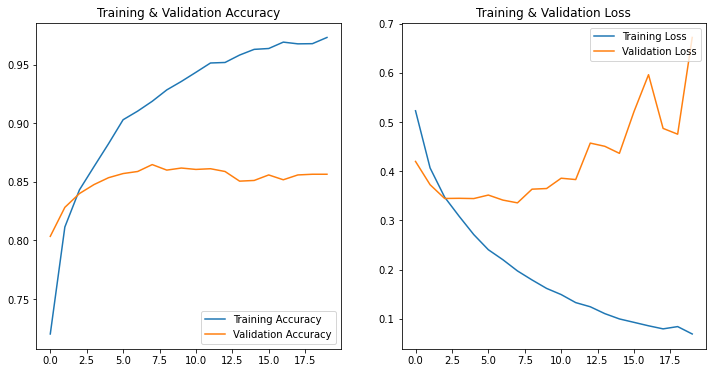

In [41]:
plot_history(20, history)

## Pickle & Reload Model

In [42]:
model.save('/content/drive/My Drive/Great Learning/Capstone/onevsrest_model.h5')

model.save_weights('/content/drive/My Drive/Great Learning/Capstone/onevsrest_model_weights.h5')

#Second Model

## Again Import Data

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
df = pd.read_pickle("/content/drive/My Drive/Great Learning/Capstone/cleaned_translated_df.pkl")

In [45]:
df.head(5)

,Description,Assignment group,Language,Translated Description,Cleaned Description,Translated Description After Clean,Language After Cleaned and Translated
0,login issue -verified user details.(employee# ...,GRP_0,en,login issue -verified user details.(employee# ...,login issue verify user detail employee manage...,login issue verify user detail employee manage...,en
1,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,GRP_0,en,outlook _x000D_\n_x000D_\nreceived from: hmjdr...,outlook team meeting skype meeting etc not app...,outlook team meeting skype meeting etc not app...,en
2,cant log in to vpn _x000D_\n_x000D_\nreceived ...,GRP_0,en,cant log in to vpn _x000D_\n_x000D_\nreceived ...,can not log vpn not log vpn best,can not log vpn not log vpn best,en
3,unable to access hr_tool page unable to access...,GRP_0,en,unable to access hr_tool page unable to access...,unable access hr tool page unable access hr to...,unable access hr tool page unable access hr to...,it
4,skype error skype error,GRP_0,da,skype error skype error,skype error skype error,skype error skype error,da


In [46]:
df.shape

(8500, 7)

In [47]:
 len(df[df['Assignment group']=='GRP_0'])

3976

## Exclude all the records belongs to GRP_0

In [48]:
df = df[(df['Assignment group']!='GRP_0')]

In [49]:
df

,Description,Assignment group,Language,Translated Description,Cleaned Description,Translated Description After Clean,Language After Cleaned and Translated
6,event: critical:HostName_221.company.com the v...,GRP_1,en,event: critical:HostName_221.company.com the v...,event critical hostname company value mountpoi...,event critical hostname company value mountpoi...,en
17,"when undocking pc , screen will not come back ...",GRP_3,en,"when undocking pc , screen will not come back ...",undocking pc screen not come back undocking pc...,undocking pc screen not come back undocking pc...,en
32,duplication of network address. \n\nreceived f...,GRP_4,en,duplication of network address. \n\nreceived f...,duplication network address gentle two device ...,duplication network address gentle two device ...,en
43,please reroute jobs on printer01 to printer02 ...,GRP_5,en,please reroute jobs on printer01 to printer02 ...,please reroute job printer printer issue need ...,please reroute job printer printer issue need ...,en
47,job Job_1424 failed in job_scheduler at: 10/31...,GRP_6,en,job Job_1424 failed in job_scheduler at: 10/31...,job job fail job scheduler job job fail job sc...,job job fail job scheduler job job fail job sc...,en
...,...,...,...,...,...,...,...
8493,"erp fi - ob09, two accounts to be added i am ...",GRP_10,en,"erp fi - ob09, two accounts to be added i am ...",erp fi ob two account add sorry another two ac...,erp fi ob two account add sorry another two ac...,en
8494,tablet needs reimaged due to multiple issues w...,GRP_3,en,tablet needs reimaged due to multiple issues w...,tablet need reimage due multiple issue crm wif...,tablet need reimage due multiple issue crm wif...,fr
8495,emails not coming in from zz mail _x000D_\n_x0...,GRP_29,en,emails not coming in from zz mail _x000D_\n_x0...,email not come zz mail good afternoon not rece...,email not come zz mail good afternoon not rece...,en
8498,machine no est funcionando i am unable to acce...,GRP_62,en,machine no est funcionando i am unable to acce...,machine no est funcionando unable access machi...,machine no est funcionando unable access machi...,es


In [50]:
df['Assignment group'].value_counts()

GRP_8     661
GRP_24    289
GRP_12    257
GRP_9     252
GRP_2     241
         ... 
GRP_64      1
GRP_67      1
GRP_35      1
GRP_70      1
GRP_73      1
Name: Assignment group, Length: 73, dtype: int64

In [51]:
df['Assignment group'].value_counts().head(50)

GRP_8     661
GRP_24    289
GRP_12    257
GRP_9     252
GRP_2     241
GRP_19    215
GRP_3     200
GRP_6     184
GRP_13    145
GRP_10    140
GRP_5     129
GRP_14    118
GRP_25    116
GRP_33    107
GRP_4     100
GRP_29     97
GRP_18     88
GRP_16     85
GRP_17     81
GRP_31     69
GRP_7      68
GRP_34     62
GRP_26     56
GRP_40     45
GRP_28     44
GRP_41     40
GRP_15     39
GRP_30     39
GRP_42     37
GRP_20     36
GRP_45     35
GRP_1      31
GRP_22     31
GRP_11     30
GRP_21     29
GRP_47     27
GRP_62     25
GRP_48     25
GRP_23     25
GRP_60     20
GRP_39     19
GRP_27     18
GRP_37     16
GRP_44     15
GRP_36     15
GRP_50     14
GRP_65     11
GRP_53     11
GRP_52      9
GRP_55      8
Name: Assignment group, dtype: int64

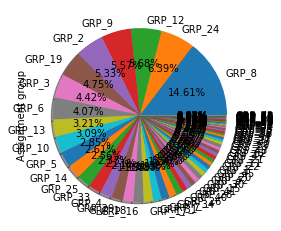

In [52]:
df['Assignment group'].value_counts().plot.pie(autopct='%1.2f%%',shadow=True)

## Encode Groups

In [53]:
from sklearn.preprocessing import LabelEncoder
le_other_groups = LabelEncoder()
df['Assignment group']= le_other_groups.fit_transform(df['Assignment group'])

In [54]:
df.head()

,Description,Assignment group,Language,Translated Description,Cleaned Description,Translated Description After Clean,Language After Cleaned and Translated
6,event: critical:HostName_221.company.com the v...,0,en,event: critical:HostName_221.company.com the v...,event critical hostname company value mountpoi...,event critical hostname company value mountpoi...,en
17,"when undocking pc , screen will not come back ...",22,en,"when undocking pc , screen will not come back ...",undocking pc screen not come back undocking pc...,undocking pc screen not come back undocking pc...,en
32,duplication of network address. \n\nreceived f...,33,en,duplication of network address. \n\nreceived f...,duplication network address gentle two device ...,duplication network address gentle two device ...,en
43,please reroute jobs on printer01 to printer02 ...,44,en,please reroute jobs on printer01 to printer02 ...,please reroute job printer printer issue need ...,please reroute job printer printer issue need ...,en
47,job Job_1424 failed in job_scheduler at: 10/31...,55,en,job Job_1424 failed in job_scheduler at: 10/31...,job job fail job scheduler job job fail job sc...,job job fail job scheduler job job fail job sc...,en


In [55]:
df['Assignment group'].value_counts()

71    661
16    289
3     257
72    252
11    241
     ... 
60      1
63      1
28      1
67      1
70      1
Name: Assignment group, Length: 73, dtype: int64

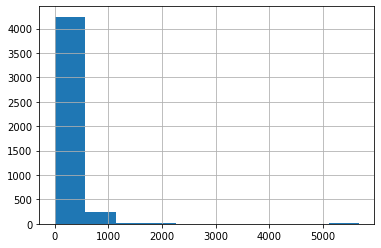

In [56]:
df['Translated Description After Clean'].map(lambda x: len(x)).hist()

## Upsampling with Synonyms Approach

In [73]:
index_word = {0: ''}
for word in tokenizer.word_index.keys():
    index_word[tokenizer.word_index[word]] = word

Tokenization here is only meant for Upscaling the data

In [74]:
maxLength = max([len(text) for text in df['Translated Description After Clean']])
print(maxLength)
maxLength=1000
print(maxLength)
tokenizer = Tokenizer(num_words=15000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
tokenizer.fit_on_texts(df['Translated Description After Clean'])
X = tokenizer.texts_to_sequences(df['Translated Description After Clean'])
X = pad_sequences(X, maxlen = maxLength)
Y = df['Assignment group']

5670
1000


In [75]:
embeddings_index = {}
f = open('/content/drive/My Drive/Great Learning/Projects/NLP/glove.6B.100d.txt', encoding="utf8")
#f = open('/content/drive/My Drive/Great Learning/Projects/NLP/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [76]:
wordsinProcessedCorpus= len(tokenizer.word_index)
print(wordsinProcessedCorpus)

9920


In [77]:
embedding_matrix = np.zeros((wordsinProcessedCorpus+1, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [78]:
from sklearn.neighbors import NearestNeighbors

synonyms_number = 5
word_number = 15000

In [79]:
nn = NearestNeighbors(n_neighbors=synonyms_number+1).fit(embedding_matrix) 

In [80]:
neighbours_mat = nn.kneighbors(embedding_matrix[1:word_number])[1]

In [81]:
synonyms = {x[0]: x[1:] for x in neighbours_mat}

In [82]:
 np.random.randint(1, word_number, 10)

array([  493,  1518,  4577,  9499, 11138,  4777, 11192, 13225, 14893,
       11786])

In [83]:
index_word[10]

'tool'

In [84]:
Y.value_counts()

71    661
16    289
3     257
72    252
11    241
     ... 
60      1
63      1
28      1
67      1
70      1
Name: Assignment group, Length: 73, dtype: int64

In [85]:
X_pos = X[Y==60]

In [86]:
X_pos.shape[0]

1

In [87]:
def modify_sentence(sentence, synonyms, p=0.5):
    for i in range(len(sentence)):
        if np.random.random() > p:
            try:
                syns = synonyms[sentence[i]]
                sentence[i] = np.random.choice(syns)
            except KeyError:
                pass
    return sentence

In [88]:
indexes = np.random.randint(0, X_pos.shape[0], 2)
for x in X_pos[indexes]:
    sample =  np.trim_zeros(x)
    sentence = ' '.join([index_word[x] for x in sample])
    print(sentence)

    modified = modify_sentence(sample, synonyms)
    print(modified)
    sentence_m = ' '.join([index_word[x] for x in modified])
    print(sentence_m)
    
    print(' ')

high access not order check sge kann labeldrucker sgwipoxns inspectorruleid through cms werden adoption chtrhysdrystal above external time noris item connect review erp layout check message external time erp summary werden inspectorruleid assistance access cms component assistance pds sdjdskjdkyr
[ 190  814    2   76  303 7550  359 4648 7551 1561  496 1870 2178 2845
 7552  621 2815 3416 1149  242   46  424   24 1353  303   54 9326 5884
  507 2642  577 1561  845   18  163 1473  845 2644 7553]
telephone wird not order exe sge kann labeldrucker sgwipoxns inspectorruleid occurrence cms cve azm chtrhysdrystal above sridthshar incorrectly noris item connect review hostname zz exe message standalone illegal value av werden inspectorruleid assistance access explorer component assistance orde sdjdskjdkyr
 
high access not order check sge kann labeldrucker sgwipoxns inspectorruleid through cms werden adoption chtrhysdrystal above external time noris item connect review erp layout check message e

In [89]:
661-len(df[df['Assignment group'] == 6])

622

In [90]:
df.shape

(4524, 7)

In [91]:
df_temp = pd.DataFrame()
for grp in df['Assignment group'].unique():
    balance = 661-len(df[df['Assignment group'] == grp])
    if balance>0:
      print(balance)
      X_pos = X[Y==grp]
      indexes = np.random.randint(0, X_pos.shape[0], balance)
      for x in X_pos[indexes]:
        sample =  np.trim_zeros(x)
        modified = modify_sentence(sample, synonyms)
        sentence_m = ' '.join([index_word[x] for x in modified])
        df2 = {'Translated Description After Clean': sentence_m, 'Assignment group': grp}
        df_temp = df_temp.append(df2, ignore_index = True)

630
461
561
532
477
593
409
521
631
404
516
543
622
576
580
573
446
420
625
632
630
636
372
545
605
643
617
564
622
592
554
599
660
646
645
658
642
616
621
624
656
646
626
655
634
636
655
647
653
652
650
659
653
658
659
658
655
641
660
657
636
658
660
650
657
660
658
659
660
659
659
660


In [92]:
df_temp['Assignment group'].value_counts()

70.0    660
63.0    660
28.0    660
67.0    660
57.0    660
       ... 
10.0    446
11.0    420
72.0    409
3.0     404
16.0    372
Name: Assignment group, Length: 72, dtype: int64

In [93]:
df_up_sampled=pd.DataFrame()
df2 = {'Translated Description After Clean':'NA', 'Assignment group': ''}
df_up_sampled = df_up_sampled.append(df2, ignore_index = True)

In [94]:
df_up_sampled = pd.DataFrame({ 
    "Translated Description After Clean": df['Translated Description After Clean'],
    "Assignment group": df['Assignment group']
})

In [95]:
df_temp_sampled = pd.DataFrame({ 
    "Translated Description After Clean": df_temp['Translated Description After Clean'],
    "Assignment group": df_temp['Assignment group']
})

In [96]:
df_temp_sampled.shape

(43729, 2)

In [97]:
df.shape

(4524, 7)

In [98]:
df_up_sampled.shape

(4524, 2)

In [99]:
df_up_sampled = df_up_sampled.append(df_temp_sampled, ignore_index = True)

In [100]:
df_up_sampled.shape

(48253, 2)

In [101]:
df_up_sampled

,Translated Description After Clean,Assignment group
0,event critical hostname company value mountpoi...,0.0
1,undocking pc screen not come back undocking pc...,22.0
2,duplication network address gentle two device ...,33.0
3,please reroute job printer printer issue need ...,44.0
4,job job fail job scheduler job job fail job sc...,55.0
...,...,...
48248,schulungsraum exact defekt dank list informati...,70.0
48249,schulungsraum ignore value work sls informatio...,70.0
48250,schulungsraum wdleell ad work route informatio...,70.0
48251,schulungsraum newly erp work list information ...,70.0


In [103]:
df_up_sampled.to_pickle("/content/drive/My Drive/Great Learning/Capstone/upscaled_df_other_73_groups.pkl")

## Again Tokenize on the Upscaled data

In [104]:
maxLength = max([len(text) for text in df_up_sampled['Translated Description After Clean']])
print(maxLength)
maxLength=1000
print(maxLength)
tokenizer = Tokenizer(num_words=15000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
tokenizer.fit_on_texts(df_up_sampled['Translated Description After Clean'])
X = tokenizer.texts_to_sequences(df_up_sampled['Translated Description After Clean'])
X = pad_sequences(X, maxlen = maxLength)
Y = df_up_sampled['Assignment group']

7471
1000


In [105]:
len(X[0])

1000

In [106]:
Y

0         0.0
1        22.0
2        33.0
3        44.0
4        55.0
         ... 
48248    70.0
48249    70.0
48250    70.0
48251    70.0
48252    70.0
Name: Assignment group, Length: 48253, dtype: float64

In [107]:
len(Y.value_counts())

73

In [108]:
print(X.shape)

(48253, 1000)


## Train & Test Split

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
    test_size=0.20, random_state=0)

In [110]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(38602, 1000)
(38602,)
(9651, 1000)
(9651,)


In [111]:
print(X_train.shape[1])

1000


In [112]:
len(y_train.value_counts())

73

In [113]:
len(y_test.value_counts())

73

In [114]:
wordsinProcessedCorpus= len(tokenizer.word_index)
print(wordsinProcessedCorpus)

11614


In [115]:
embedding_matrix = np.zeros((wordsinProcessedCorpus, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [116]:
len(embedding_matrix)

11614

## Model to predict all groups

In [117]:
model = Sequential()
model.add(Embedding(wordsinProcessedCorpus, 100, weights=[embedding_matrix], trainable=True, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(units=128, dropout=0.3)))
model.add(Dense(100, activation='relu'))
model.add(Dense(len((pd.Series(y_train)).unique()), activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 100)         1161400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 100)               25700     
                                                                 
 dense_5 (Dense)             (None, 73)                7373      
                                                                 
Total params: 1,428,969
Trainable params: 1,428,969
Non-trainable params: 0
_________________________________________________________________


In [118]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(monitor="val_loss",
                  mode="min",
                  verbose=1,
                  patience=2,
                  min_delta=0.1,
                 restore_best_weights=True)
]

In [119]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [120]:
Y

0         0.0
1        22.0
2        33.0
3        44.0
4        55.0
         ... 
48248    70.0
48249    70.0
48250    70.0
48251    70.0
48252    70.0
Name: Assignment group, Length: 48253, dtype: float64

In [121]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=200, verbose=1)

Epoch 1/15
194/194 [==============================] - 112s 554ms/step - loss: 3.0220 - accuracy: 0.2953 - val_loss: 2.0479 - val_accuracy: 0.4721
Epoch 2/15
194/194 [==============================] - 106s 547ms/step - loss: 1.7183 - accuracy: 0.5536 - val_loss: 1.5354 - val_accuracy: 0.5990
Epoch 3/15
194/194 [==============================] - 106s 545ms/step - loss: 1.2849 - accuracy: 0.6554 - val_loss: 1.0199 - val_accuracy: 0.7174
Epoch 4/15
194/194 [==============================] - 105s 544ms/step - loss: 0.9154 - accuracy: 0.7433 - val_loss: 0.8342 - val_accuracy: 0.7671
Epoch 5/15
194/194 [==============================] - 106s 546ms/step - loss: 0.7564 - accuracy: 0.7846 - val_loss: 0.7242 - val_accuracy: 0.7965
Epoch 6/15
194/194 [==============================] - 106s 546ms/step - loss: 0.6168 - accuracy: 0.8207 - val_loss: 0.6535 - val_accuracy: 0.8135
Epoch 7/15
194/194 [==============================] - 107s 551ms/step - loss: 0.5288 - accuracy: 0.8440 - val_loss: 0.5949 -

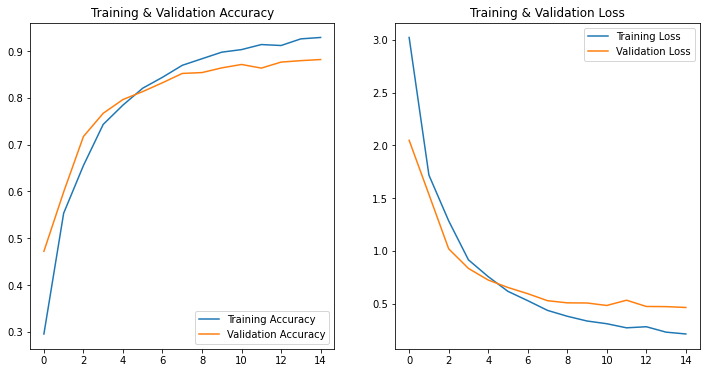

In [122]:
plot_history(15, history)

### Pickle & Reload Model

In [123]:
model.save('/content/drive/My Drive/Great Learning/Capstone/model.h5')

model.save_weights('/content/drive/My Drive/Great Learning/Capstone/model_weights.h5')